# Car Insurance Risk Analysis

This notebook analyzes vehicle safety based on insurance claim data across different metrics:
- Collision: Cost index for collision claims
- Comprehensive (Comp): Cost index for comprehensive claims including theft
- DCPD (Direct Compensation Property Damage): Cost index for property damage claims
- AB (Accident Benefits): Frequency index for personal injury claims

In [1]:
!pip install pandas numpy seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

# Set style for better visualizations
sns.set_theme() 
sns.set_palette('husl')

In [ ]:
# Load and prepare the data
df = pd.read_excel('hcmu_e_2024.xlsx')

# Clean column names
df.columns = df.columns.str.strip()

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nSample of the data:")
print(df.head())

In [3]:
# Convert numerical columns from object to float
cols_to_convert = ['Collision', 'Comp', 'DCPD','AB']

df = pd.read_excel('hcmu_e_2024.xlsx') #reset df to original state
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nDataFrame after conversion using pd.to_numeric (errors='coerce'):")
print(df)
print(df.dtypes)


DataFrame after conversion using pd.to_numeric (errors='coerce'):
      Collision   Comp   DCPD     AB  Make          Model Body Style  \
0          48.0    9.0  107.0   98.0  ACURA       CSX 4DR         4D   
1          62.0   29.0   76.0  527.0  ACURA       CSX 4DR         4D   
2          65.0   19.0  140.0  591.0  ACURA       CSX 4DR         4D   
3          79.0   15.0   84.0   97.0  ACURA       CSX 4DR         4D   
4          71.0   16.0   88.0  253.0  ACURA       CSX 4DR         4D   
...         ...    ...    ...    ...    ...           ...        ...   
4248      111.0  167.0  168.0  110.0  VOLVO  XC90 4DR AWD        SUV   
4249       71.0  149.0  112.0   53.0  VOLVO  XC90 4DR AWD        SUV   
4250      169.0  116.0  173.0   49.0  VOLVO  XC90 4DR AWD        SUV   
4251      123.0   74.0  225.0  187.0  VOLVO  XC90 4DR AWD        SUV   
4252      137.0   84.0  225.0   34.0  VOLVO  XC90 4DR AWD        SUV   

      Model Year  
0           2006  
1           2007  
2          

In [5]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()
# Remove leading/trailing whitespace
df.columns = df.columns.str.strip()

In [6]:
def calculate_safety_score(row):
    """Calculate overall safety score (lower is better)"""
    # Convert missing values to median for each column
    collision = row['collision'] if pd.notna(row['collision']) else df['collision'].median()
    comp = row['comp'] if pd.notna(row['comp']) else df['comp'].median()
    dcpd = row['dcpd'] if pd.notna(row['dcpd']) else df['dcpd'].median()
    ab = row['ab'] if pd.notna(row['ab']) else df['ab'].median()
    
    # Normalize and weight different factors
    # Higher weights for collision and accident benefits as they're more safety-critical
    weights = {
        'collision': 0.35,  # Collision severity
        'comp': 0.15,      # Comprehensive claims
        'dcpd': 0.20,      # Property damage
        'ab': 0.30         # Personal injury
    }
    
    return (
        collision * weights['collision'] +
        comp * weights['comp'] +
        dcpd * weights['dcpd'] +
        ab * weights['ab']
    )

# Calculate safety scores
df['safety_score'] = df.apply(calculate_safety_score, axis=1)

In [34]:
def get_top_safe_vehicles(df: pd.DataFrame, body_style: str, top_n: int = 5) -> pd.DataFrame:
    """Get the top N safest vehicles for a specific body style"""
    style_df = df[df['body style'] == body_style].copy()

    #Check if the style exists. If not, return an empty DataFrame
    if style_df.empty:
        print(f"No vehicles found for body style: {body_style}")
        return pd.DataFrame()

    columns_to_select = ['make', 'model', 'model year', 'safety_score', 'collision', 'comp', 'dcpd', 'ab']
    existing_columns = [col for col in columns_to_select if col in style_df.columns]

    return (
        style_df
        .sort_values('safety_score', ascending = True) #Sort in ascending order to get the top safest
        .head(top_n)
        [existing_columns]
    )

# Display top 5 safest vehicles for each body style
for style in df['body style'].unique():
    print(f"\nTop 5 Safest {style} Vehicles:")
    print(get_top_safe_vehicles(df, style))


Top 5 Safest 4D Vehicles:
              make                     model  model year  safety_score  \
1393          FORD                TAURUS 4DR        2006         17.25   
1541  FORD/MERCURY  FIVE HUNDRED/MONTEGO 4DR        2005         18.55   
591      CHEVROLET              CAVALIER 4DR        2005         20.05   
1542  FORD/MERCURY  FIVE HUNDRED/MONTEGO 4DR        2006         20.85   
1554  FORD/MERCURY          TAURUS/SABLE 4DR        2005         23.85   

      collision  comp  dcpd    ab  
1393       25.0  12.0  26.0   5.0  
1541       22.0   9.0  25.0  15.0  
591        24.0  17.0  26.0  13.0  
1542       34.0  15.0  26.0   5.0  
1554       25.0  12.0  17.0  33.0  

Top 5 Safest SUV Vehicles:
         make             model  model year  safety_score  collision  comp  \
2210     JEEP      WRANGLER 4WD        2007         17.10       24.0  28.0   
2215     JEEP      WRANGLER 4WD        2012         18.85       23.0  26.0   
2211     JEEP      WRANGLER 4WD        2008       

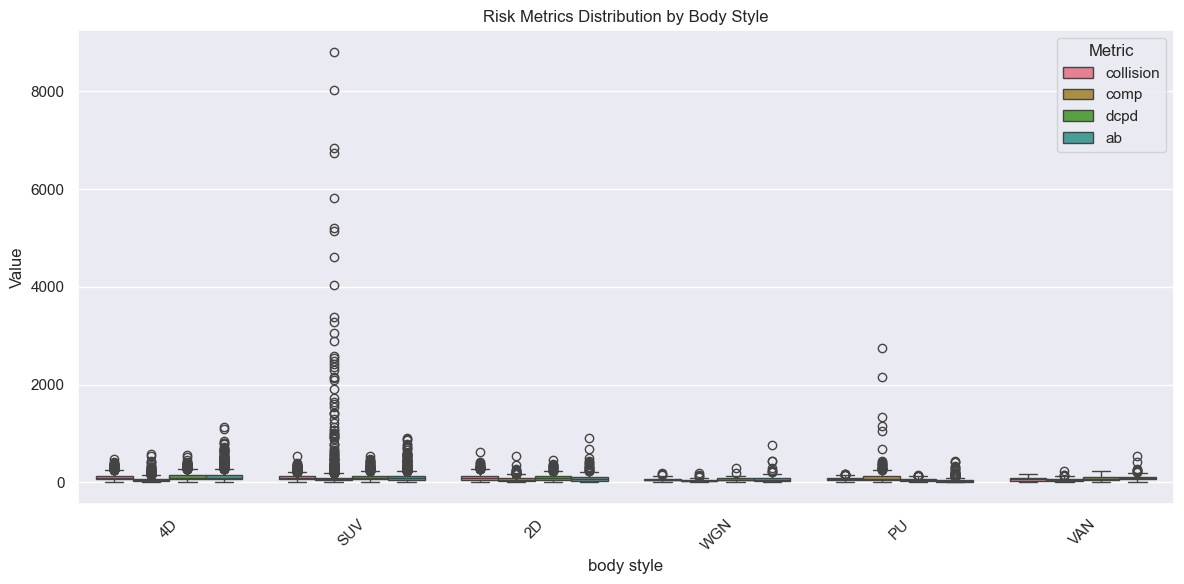

In [8]:
# Visualization 1: Risk Metrics by Body Style
plt.figure(figsize=(12, 6))

metrics = ['collision', 'comp', 'dcpd', 'ab']
data_melted = df.melt(id_vars=['body style'], value_vars=metrics, var_name='Metric', value_name='Value')

sns.boxplot(x='body style', y='Value', hue='Metric', data=data_melted)
plt.title('Risk Metrics Distribution by Body Style')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

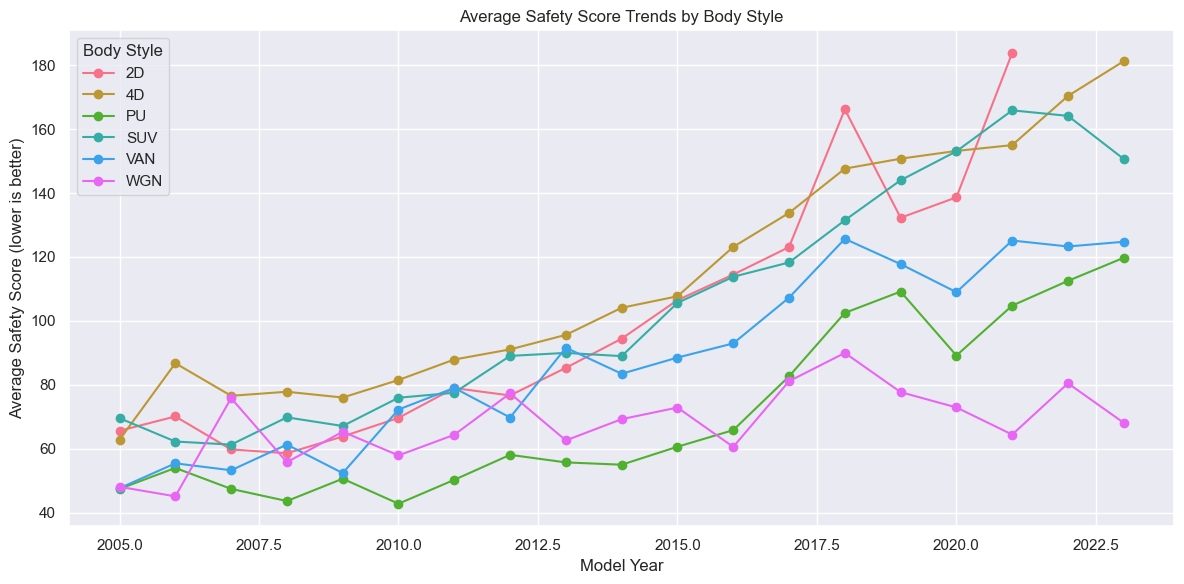

In [9]:
# Visualization 2: Safety Score Trends Over Years
plt.figure(figsize=(12, 6))

yearly_avg = df.groupby(['model year', 'body style'])['safety_score'].mean().unstack()

for style in yearly_avg.columns:
    plt.plot(yearly_avg.index, yearly_avg[style], marker='o', label=style)

plt.title('Average Safety Score Trends by Body Style')
plt.xlabel('Model Year')
plt.ylabel('Average Safety Score (lower is better)')
plt.legend(title='Body Style')
plt.grid(True)
plt.tight_layout()
plt.show()

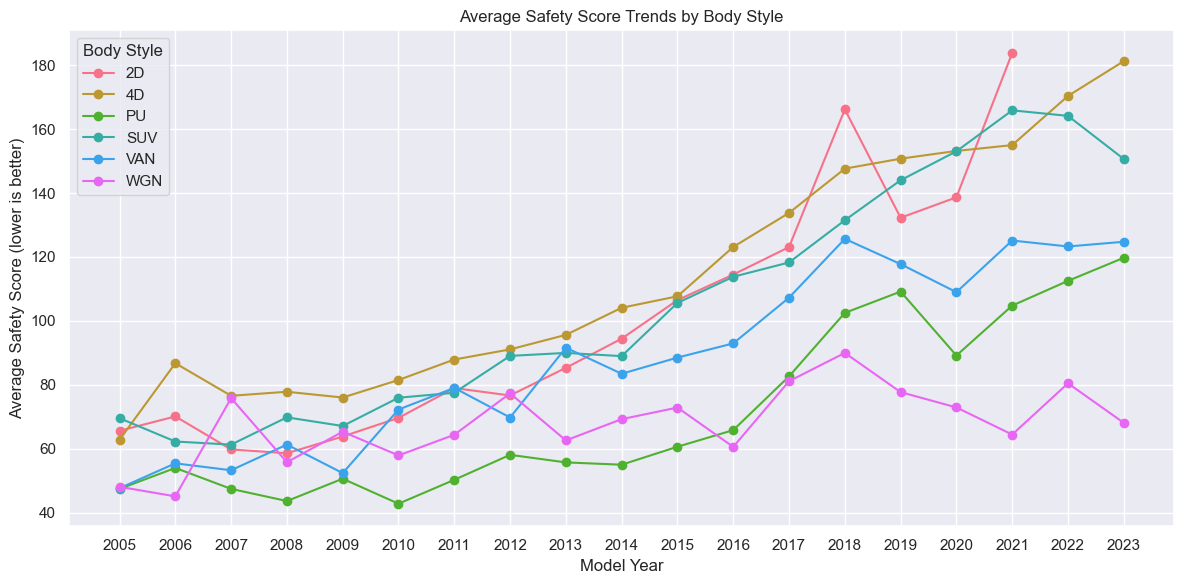

In [10]:
# Model Year shouldn't be decimals. To fix this,
import matplotlib.ticker as mticker
df['model year'] = df['model year'].astype(int)  # Crucial: Convert BEFORE grouping

yearly_avg = df.groupby(['model year', 'body style'])['safety_score'].mean().unstack()

plt.figure(figsize=(12, 6))

for style in yearly_avg.columns:
    plt.plot(yearly_avg.index, yearly_avg[style], marker='o', label=style)

plt.title('Average Safety Score Trends by Body Style')
plt.xlabel('Model Year')
plt.ylabel('Average Safety Score (lower is better)')
plt.legend(title='Body Style')
plt.grid(True)

# Use ticker to force integer ticks on x-axis
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1)) # Set ticks every 1 unit (year)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d')) # Format as integer

plt.tight_layout()
plt.show()

In [32]:
# For more meaningful results in the make performance, calculate the number of models per make
models_per_make = df.groupby('make')['model'].count()

# Calculate the median number of models
median_models = models_per_make.median()

print(f"Median number of models per make: {median_models}")

# Let's also have some summary statistics
print("\nSummary Statistics of Models per Make:")
print(models_per_make.describe())

Median number of models per make: 43.0

Summary Statistics of Models per Make:
count     57.000000
mean      74.614035
std       83.855265
min        1.000000
25%       10.000000
50%       43.000000
75%      126.000000
max      368.000000
Name: model, dtype: float64


In [33]:
# Analysis of Make Performance
min_models = 43
make_analysis = df.groupby('make').agg({
    'safety_score': 'mean',
    'collision': 'mean',
    'comp': 'mean',
    'dcpd': 'mean',
    'ab': 'mean',
    'model': 'count'
}).round(2)

make_analysis = make_analysis.rename(columns={'model': 'number of models'})

# Filter makes based on the minimum number of models
make_analysis_filtered = make_analysis[make_analysis['number of models'] >= min_models]

make_analysis_filtered = make_analysis_filtered.sort_values('safety_score')

print(f"Manufacturer Performance Analysis (Top 10, at least {min_models} models):")
print(make_analysis_filtered.head(10))

#If no makes meet the requirement
if make_analysis_filtered.empty:
    print(f"No makes with at least {min_models} models found.")

Manufacturer Performance Analysis (Top 10, at least 43 models):
               safety_score  collision    comp   dcpd     ab  number of models
make                                                                          
PONTIAC               49.44      33.72   17.40  32.31  81.61                57
FORD/MERCURY          53.03      33.94   21.88  35.14  92.09                43
BUICK                 68.17      70.30   37.93  65.56  82.56                43
SUBARU                74.93      74.78   56.96  83.83  76.75               126
VOLVO                 75.93      78.84   62.67  95.96  66.00                65
CHEVROLET             76.10      77.88   46.86  70.90  89.96               180
MINI                  77.46      86.37   51.07  90.62  71.84                45
FORD                  77.88      81.93   94.55  70.43  69.26               266
CHEVROLET/GMC         81.89      71.38  170.90  62.73  62.48               174
JEEP                  84.66      74.51  137.76  68.62  79.97       